# Synthetic HI Spectra for Spiral Galaxies

### By Juan Cabanela (Minnesota State University Moorhead)

This program is designed to allow you to model the neutral hydrogen line spectrum (the so-called 21-cm line) of a model spiral galaxy as viewed from outside the galaxy.  In other words, the model radio spectrum of spiral galaxies.  We do this for
1. Unresolved "single-dish" Arecibo Observatory spectra where we assume the entire galaxy falls within the radio beam (assuming a 145 arcsecond beam)with a 5 km/s velocity resolution
2. Resolved aperture synthesis spectra (as might be produced by the VLA) in which we can resolve the galaxy, essentially getting the spectrum for every point within the galaxy.

This code generates spectra for model spiral galaxies with the HI gas density profile (the density versus radius) and rotation curve initially assumed to be similar to the Milky Way. However, you can sketch any rotation curve or HI gas density profile on those plots and the modelled unresolved "single-dish" spectrum and the resolved "aperture synthesis" velocity map are updated.  You can also modify the redshift $cz$ or gas velocity dispersion by sliding thei respective sliders.

In [1]:
# Author: Juan Cabanela
#
# Originally written in perl (using pgplot libraries) in 2002, this could was ported to a python script 
# using matplotlib in 2013 (roughly) and in 2017 it was moved to a Jupyter notebook.  The current version
# was ported in summer 2019 to allow use of ipywidget widgets as controls for the l-v diagram generator.

In [2]:
# Import necessary libraries
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt

import random
import string
import numpy as np
import io
import sys
import bqplot as bq
from ipywidgets import Layout
from ipywidgets import widgets
from IPython.display import display

# Import specific functions designed for galaxy model building
from galaxyparam import *

In [3]:
### Configure some basic settings for this notebook here
#
# You will need to set up a few things before running this Jupyter notebook (the defaults are fine for the first run):
#
# Changing the galaxy model: You may want to edit galaxy_datafile with the filename of the file describing the 
#    galaxy.  That file must be in the same directory with the IPython notebook.  That file is a 3 column (where 
#    the columns are comma-seperated) text file.  The three columns are:
#
#    1. radius (in kpc): Radius of this data point in kpc
#    2. rot_vel (in km/s): Rotational velocity of this data point in km/s
#    3. density (in atoms/cm^3): Assumed gas density at this point (in atoms/cm^3)
#    The 'header' row is required to be "radius,rot_vel,density" or this script will not properly read the file.
#
#   After running the default realistic Milky Way model, you will create a new galaxy model (in a different file
#   than the original galaxy_description.csv) to represent a Keplerian (~ r^{-1/2}) rotation curve.  
#   You will need to set galaxy_datafile to point to the file containing the new model.  Don't worry about 
#   evenly spacing data points in radius.  The part of the script below that reads this datafile will 
#   interpolate between your radial points with a spline fit, so it is pretty robust as smoothly fitting 
#   between your data points.
#
# Changing the image filename: Set up the image_filename for the file you will want to save the final image.
#    It must end with .jpg, .png, or .pdf.

# Initialize filenames and parameters related to data import
galaxy_datafile = "data/galaxy_description.csv"  # File containing rotation curve and density data
HIradius = 25    # Assumed radius of HI disk
dens_drop = 0.01  # Drop in density per kpc of radius (in atoms/cm^3)
# Load the Galaxy Data (go out sqrt(2) times HI radius to allow for square computational grid later)
(rad_raw, rotvel_raw, density_raw) = LoadData(galaxy_datafile, np.sqrt(2)*HIradius, dens_drop) 

image_directory = "tmp"  # Name of temporary directory to store images in

randkey = ''.join(random.choice(string.ascii_letters) for i in range(5) )
basename = "Synthetic_HISpectra"
image_filename = "{0}_{1}.png".format(basename, randkey)     # Name of the final PNG image file to generate

#
# Constants related to the spline fit routine
#
dr_spline = 0.1    # Step size in kpc for spline fit (global, so it can be used within functions)

# Make the initial spline fit to the rotation curve and gas density curve data
rad_spline, rotvel_spline, density_spline = spline_curves(rad_raw, rotvel_raw, density_raw, dr_spline)

In [4]:
############################################
# Initialize Constants and other variables #
############################################
deg2rad = np.pi/180  # Radians per degree

# Constants related to computing line of sight velocity
# of different points in the galaxy's disk.
radial_step = 0.05   # Step size [in kpc]
theta_step = 1       # Step size [in degrees ]
vel_step = 2         # Velocity bin size [in km/s]

# Additional constants defined for modeling the HI 
# spectrum of a galaxy as seen from the outside.
incl = 75.0     # Inclination of galaxy between 0 and 85 [degrees] 
cz   = 5000.0   # Redshift of galaxy in km/s

H_0 = 72      # Assumed value of Hubble's constant (in km/s/Mpc)

dx = 0.5           # Stepsize for integrating over galaxy (x,y) grid (in Kpc)
dz = 1             # Assumed thickness of galaxy here (in Kpc)
vel_sigma = 17     # Assumed FWHM of gas velocity distribution width (in km/s)  

dv = 5              # Channel width of unresolved dish spectra [Arecibo@21cm] (in km/s)
rstep = 0.05        # Stepsize in radius (kpc) for fit of rotation & density curve
velocity_step = 20  # Velocity step size in contour plots
dens_step = 0.1     # Density step size in contour plots
half_width = 1000   # Allowed velocity difference from cz (in km/s)
maxdens = 1.0       # Maximum allowed gas density (in atoms/cm^2)
maxvel = 400        # Maximum rotational velocity allowed (in km/s)

# Constants related to converting gas density from atoms/cm^3 to
# solar masses/Kpc^3.
vol_factor = (3.09e21)*(3.09e21)*(3.09e21)  # cm^3/Kpc^3
mass_factor = 1.67e-27                      # kg/atom
solar_factor = 1.99e30                      # kg/M_solar
factor = vol_factor*mass_factor/solar_factor  

In [5]:
##########################
# FUNCTION LIBRARY BELOW #
##########################

In [6]:
def check_beam(cz, H_0, radius, beam_fwhm = 145):
    # Compute size of beam in Kpc at galaxy and confirm galaxy unresolved.
    # Assumed default beam size (beam_fwhm) is Arecibo (in arcseconds).
    global cz_notice
    
    # Assuming a sharp edged radio beam, which is not realistic...
    beam_galaxy = (beam_fwhm/206265.)*(cz/H_0)*1000.
    
    # Check this beam radius versus galaxy radius and report back
    if (beam_galaxy < radius): 
        cz_notice.value = "<p style=\"color: red; font-size: smaller;\"><B>WARNING:</B> Galaxy is resolved by Arecibo beam!!!</P>"
    else:
        cz_notice.value = ""

In [7]:
def build_galaxy_velcube(rotvel_prof, density_prof, HIradius, dx, dr_spline):
    #
    # This function builds a popultion of noisy velocity cubes (velocity 
    # versus position on sky) for a galaxy, along with a (simple) 
    # density cube.  It returns that data.
    #
    # Refactored the previous approach of looping over all the 
    # x,y positions in the galaxy's plane and converting them individually
    # into polar (r, theta) positions which allow rotational velocity
    # and gas density lookup.  The major change was to use array 
    # arithmetic and thus speed up the computations immensely versus 
    # inefficient loops.
    #
    # This was done during the migration to an ipywidgets interface in
    # summer 2019.

    # Build arrays of positions in the galaxy in cartesian coordinates
    # and then in polar coordinates.
    radspace = np.linspace(-HIradius, HIradius, int(((2*HIradius)/dx)+1))
    x, y_gal = np.meshgrid(radspace, radspace)
    (r, theta) = RotCoord(x, y_gal)
    # Compute position on plane in the sky (assuming thin disk, so no z component)
    y = y_gal*np.cos(incl*deg2rad)

    # Retrieve HI density and rotational velocities for all galaxy positions
    R_idx = np.floor(r/dr_spline).astype(np.int64)
    dens_0 = density_prof[R_idx] # Faceon density at each point
    vel  = rotvel_prof[R_idx]  # Rotational velocity at each point

    # Project these rotational velocities to line of sight velocities.
    # Assumes positive y-axis pointed toward the earth if the inclination 
    # angle i was 90 degrees.
    v_rad = vel*np.cos(theta)*np.sin(incl*deg2rad)

    # Generate population of n_copies copies of the velocities with 
    # a Gaussian scatter of velocities added to them.  Also make copies
    # of the gas densities and use that to compute the HI masses involved.
    n_copies = 20
    v_rad_pop = np.array([v_rad]*n_copies)
    v_rad_pop += np.random.normal(loc=0, scale=vel_sigma, size=v_rad_pop.shape)
    dens_0_pop = np.array([dens_0]*n_copies)
    
    return (x, y, v_rad_pop, dens_0_pop)

In [8]:
def unresolved_spectra(vrad_pop, dens_pop, cz):
    global H_0, half_width, dv
    
    #####################################
    # GENERATING THE UNRESOLVED SPECTRA #
    #####################################

    # Construct numpy array for single dish spectram storage
    chvel = np.arange(cz-half_width, cz+half_width+dv, dv)
    MassHisto = np.zeros_like(chvel)

    # Determine the unresolved spectra velocity bin (in array form)
    # and then sum of the mass contributions.
    velbin1D_pop = np.floor((vrad_pop + half_width)/dv).astype(np.int64)
    vels1D = velbin1D_pop.reshape(velbin1D_pop.size)
    
    # Determine mass distribution in the galaxy
    dens = dens_pop.reshape(dens_pop.size)
    mass = factor*dens*dx*dx*dz   # mass of these particular copies

    # Record these density contributions to approprate velbin and lonbin of dens_map
    for i in range(vels1D.size):
            MassHisto[vels1D[i]] += mass[i]
    total_mass= np.sum(mass)   # Track the total gas mass in solar masses

    # At this point, we have a Mass histogram with the amount of HI mass in each
    # velocity bin (chvel).  We convert this into a flux array by inverting the 
    # flux to hydrogen mass equation:
    #    HI_Mass (M_sun) = (235600)*(Dist[Mpc]^2)*Integral(F*delV Jy-km/s)
    # such that (assuming a boxcar profile for the gas in each velocity channel)
    #    F = HI_Mass/(delV*235600*Dist^2) 
    mass2Jy = (dv*235600.*(cz/H_0)*(cz/H_0)) # conversion in Msolar/Jy-km/s
    unresolved_flux = MassHisto/mass2Jy
    
    return(chvel, unresolved_flux)

In [9]:
def resolved_spectra(cz, vrad_pop, dens_pop, velocity_step):
    global incl, deg2rad
    
    ##########################################
    # GENERATING THE RESOLVED VELOCITY FIELD #
    ##########################################

    # To determine the resolved spectrum, we take the previous
    # randomized copies of the velocity field and take the average
    # along the number of copies to get an average velocity
    # field.  Then add the systemic redshift
    vrad_avg = cz + np.average(vrad_pop, axis=0)

    # Store the density information (maybe for later use)
    resolved_dens= np.average(dens_pop, axis=0)  # Sum up the densities

    # Determine the values of the velocity contours to use.
    # Set the velocity limits, rounded to velocity_step
    min_resolved_vel = velocity_step*np.floor(np.min(vrad_avg)/velocity_step)
    max_resolved_vel = velocity_step*np.ceil(np.max(vrad_avg)/velocity_step)
    if (max_resolved_vel - min_resolved_vel)>200:
        vel_levels = np.linspace(min_resolved_vel, max_resolved_vel, 11)
    else: # Space every 20 km/s
        vel_levels = np.arange(min_resolved_vel, max_resolved_vel, 20)

    # Set the density limit rounded to 0.1 atom/cm^3
    max_resolved_dens = dens_step*np.ceil(np.max(resolved_dens)/dens_step)
    dens_levels = np.linspace((dens_step/2), max_resolved_dens, int(np.ceil(max_resolved_dens/(dens_step/2))) )

    return(vrad_avg, vel_levels, resolved_dens, dens_levels)

In [10]:
##
## Functions to build plots in bqplot and matplotlib (including printable ones)
##

# Set up graph width and height
graph_height = '250px'
graph_width = '400px'


def rotvel_plot(rad_spline, rotvel_spline):
    global rotcurve_spline, rotcurve_handdraw
    rotcurve_sc_x = bq.LinearScale()
    rotcurve_sc_y = bq.LinearScale()
    rotcurve_sc_y.max = maxvel
    rotcurve_sc_y.min = 0
    rotcurve_ax_x = bq.Axis(scale=rotcurve_sc_x, label='Galactocentric Radius (kpc)')
    rotcurve_ax_y = bq.Axis(scale=rotcurve_sc_y, orientation='vertical', label='Rotational Velocity (km/s)')
    rotcurve_ax_y.label_offset = '3.5em'
    rotcurve_spline = bq.Lines(x=rad_spline, y=rotvel_spline, scales={'x': rotcurve_sc_x, 'y': rotcurve_sc_y},
                             colors=['Blue'], labels=['cubic spline fit'], display_legend=False)
    rotcurve_handdraw = bq.interacts.HandDraw(lines=rotcurve_spline)
    
    return (bq.Figure(marks=[rotcurve_spline], axes=[rotcurve_ax_x, rotcurve_ax_y], 
                      title='Galaxy Rotation Curve', legend_location='bottom', 
                      interaction=rotcurve_handdraw,
                      layout=widgets.Layout(width=graph_width, height=graph_height, 
                                            fig_margin='0px 0px 0px 0px')))


def densprof_plot(rad_spline, density_spline):
    global densprof_spline, densprof_handdraw
    densprof_sc_x = bq.LinearScale()
    densprof_sc_y = bq.LinearScale()
    densprof_sc_y.max = maxdens
    densprof_sc_y.min = 0.0
    densprof_ax_x = bq.Axis(scale=densprof_sc_x, label='Galactocentric Radius (kpc)')
    densprof_ax_y = bq.Axis(scale=densprof_sc_y, orientation='vertical', label='HI Gas Density (atom/cm^3)')
    densprof_ax_y.label_offset = '3.5em'
    densprof_spline = bq.Lines(x=rad_spline, y=density_spline, scales={'x': densprof_sc_x, 'y': densprof_sc_y},
                             colors=['Blue'], labels=['cubic spline fit'], display_legend=False)
    densprof_handdraw = bq.interacts.HandDraw(lines=densprof_spline)
    return(bq.Figure(marks=[densprof_spline], axes=[densprof_ax_x, densprof_ax_y], 
                     title='Galaxy Gas Density Profile', legend_location='top', 
                     interaction=densprof_handdraw,
                     layout=widgets.Layout(width=graph_width, height=graph_height,
                                           fig_margin='0px 0px 0px 0px')))


def spectra_plots(x, y, vel, flux, vrad_map, vel_levels, dens_map, dens_levels):
    # 
    # Generate plot of LV diagram as an image

    # Clear any existing figure and create offline figure
    plt.clf()
    plt.ioff()

    # Adjust plot defaults
    mpl.rc('axes',titlesize='large')
    mpl.rc('axes',labelsize='medium')
    mpl.rc('xtick',labelsize='medium')
    mpl.rc('ytick',labelsize='medium')

    fig = plt.figure(1, facecolor='w', edgecolor='k')
    fig.set_size_inches(8, 4)

    # Set up the plot grid
    ax1 = plt.subplot2grid((1,2), (0,0))
    ax2 = plt.subplot2grid((1,2), (0,1))

    # Set up spacing being plots
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.7)

    #
    # (3) Plot the unresolved spectral profile
    #
    ax1.set_xlabel('Heliocentric Velocity (km/s)', fontsize='medium')
    ax1.set_ylabel('Flux (Jy-km/s)', fontsize='medium')
    unresolved_title = "Unresolved HI Spectra (i: {:02d}$^\circ$)".format(int(incl))
    ax1.set_title(unresolved_title, fontsize='large')
    ax1.plot(vel, flux, 'b-')
    
    #
    # (4) Plot the resolved velocity field
    #
    ax2.set_xlabel('X (kpc)', fontsize='medium')
    ax2.set_ylabel('Y (kpc)', fontsize='medium')
    ax2.set_xlim(-HIradius, HIradius)
    ax2.set_ylim(-HIradius, HIradius)
    resolved_title = "Resolved HI Velocity Field (i: {:02d}$^\circ$)".format(int(incl))
    ax2.set_title(resolved_title, fontsize='large')

    #imshow(resolved_vel, interpolation='bilinear',cmap=gray)
    cm_name = 'Greys'
    CSF = ax2.contourf(x, y, dens_map, levels=dens_levels, alpha=1, cmap = cm.get_cmap(cm_name), extend='max')
    CS = ax2.contour(x, y, vrad_map, levels=vel_levels, extend='neither', alpha=0.75, colors='k')

    # Label levels with specially formatted floats
    CS.levels = [nf(val) for val in CS.levels ]
    ax2.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=12)

    # Display the plot to a PNG memory buffer
    buf = io.BytesIO()
    fig = plt.gcf()
    fig.savefig(buf, format='png', dpi=150)
    buf.seek(0)
    pngimg = buf.read()
    buf.close()

    return(pngimg)


def make_printable_plot(b=None):
    global imgfile_name
    global rad_spline, rotvel_spline, density_spline
    global x, y, vel, flux, vrad_map, vel_levels, dens_map, dens_levels

    ######################
    #  CREATE THE PLOTS  #
    ###################### 

    # Adjust plot defaults
    mpl.rc('axes',titlesize='medium')
    mpl.rc('axes',labelsize='small')
    mpl.rc('xtick',labelsize='small')
    mpl.rc('ytick',labelsize='small')

    fig = plt.figure(1, facecolor='w', edgecolor='k')
    fig.set_size_inches(14,10)
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.4)

    #
    # (1) Plot the rotation curve
    #
    plt.subplot(221) 
    plt.xlabel('Galactocentric Radius (kpc)')
    plt.ylabel('Rotational Velocity (km/s)')
    plt.title('Galaxy Rotation Curve')
    plt.ylim(0, maxvel)
    plt.plot(rad_spline, rotvel_spline, 'b-', label='spline fit')
    
    #
    # (2) Plot the density profile
    #
    plt.subplot(222) 
    plt.xlabel('Galactocentric Radius (kpc)')
    plt.ylabel('HI Gas Density (atom/cm^3)')
    plt.title('Galaxy Gas Density Profile')
    plt.ylim(0, maxdens)
    plt.plot(rad_spline, density_spline, 'b-', label='spline fit')
    
    #
    # (3) Plot the unresolved spectral profile
    #
    plt.subplot(223) 
    plt.xlabel('Heliocentric Velocity (km/s)')
    plt.ylabel('Flux (Jy-km/s)')
    unresolved_title = "Unresolved HI Spectra (i: {:02d}$^\circ$)".format(int(incl))
    plt.title(unresolved_title)
    plt.plot(vel, flux, 'b-')

    #
    # (4) Plot the resolved velocity field
    #
    plt.subplot(224) 
    plt.xlabel('X (kpc)')
    plt.ylabel('Y (kpc)')
    plt.xlim(-HIradius, HIradius)
    plt.ylim(-HIradius, HIradius)
    resolved_title = "Resolved HI Velocity Field (i: {:02d}$^\circ$)".format(int(incl))
    plt.title(resolved_title)

    #imshow(resolved_vel, interpolation='bilinear',cmap=gray)
    cm_name = 'Greys'
    CSF = plt.contourf(x, y, dens_map, levels=dens_levels, alpha=1, cmap = cm.get_cmap(cm_name), extend='max')
    CS = plt.contour(x, y, vrad_map, levels=vel_levels, extend='neither', alpha=0.75, colors='k')

    # Label levels with specially formatted floats
    CS.levels = [nf(val) for val in CS.levels ]
    plt.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=12)

    # Save this image as a figure too
    plt.savefig(imgfile_name.value, dpi=300)
    
    # Create the image file and create a link if the filename is legitimate
    filetypes = ["jpg", "png", "pdf"]
    img_type = imgfile_name.value[-3:]
    if img_type in filetypes:
        # Store images in a temporary directory
        true_loc = "{0}/{1}".format(image_directory,imgfile_name.value)
        plt.savefig(true_loc, dpi=300)
        savelink.value="<a href=\"{}\">Click to download!</a>".format("DisplayRecentImage.ipynb")
    else:
        savelink.value="<b>Illegal image type ({})!</b>".format(img_type)

In [11]:
#
# Functions for handling interactive elements
#

def replot(b=None):
    global HIradius, dx, dr_spline, cz, velocity_step, incl
    global rad_raw, rotvel_raw, density_raw
    global rad_spline, rotvel_spline, density_spline
    global x, y, vel, flux, vrad_map, vel_levels, dens_map, dens_levels
    
    # Update the spectra plot information
    x, y, vrad_pop, dens_pop = build_galaxy_velcube(rotvel_spline, density_spline, HIradius, dx, dr_spline)
    vel, flux = unresolved_spectra(vrad_pop, dens_pop, cz)
    vrad_map, vel_levels, dens_map, dens_levels = resolved_spectra(cz, vrad_pop, dens_pop, velocity_step)

    # Update spectra plots
    spectra.value = spectra_plots(x, y, vel, flux, vrad_map, vel_levels, dens_map, dens_levels)
    

def cz_changed(change):
    global cz, H_0, HIradius
    
    # Update the cz value
    cz = change.new
    
    # Check the beam size
    check_beam(cz, H_0, HIradius)
    
    # Replot
    replot()    

def incl_changed(change):
    global incl
    
    # Update the incl value
    incl = change.new
    
    # Replot
    replot()  

def sigma_changed(change):
    global vel_sigma
    
    # Update the sigma value
    vel_sigma = change.new
    
    # Replot
    replot()    
    
def update_rotcurve(change):
    global rotcurve_spline, rad_spline, rotvel_spline, density_spline
    
    # Force any negative points to zero
    # (there doesn't seem to be a way to update handdrawn line)
    rotcurve_spline.y[rotcurve_spline.y<0] = 0
    
    # Update spline based on handdraw action on rotcurve_spline
    rotvel_spline = rotcurve_spline.y
    
    # Replot
    replot()

def update_densprof(change):
    global densprof_spline, rad_spline, rotvel_spline, density_spline

    # Force any negative points to zero
    # (there doesn't seem to be a way to update handdrawn line)
    densprof_spline.y[densprof_spline.y<0] = 0

    # Update spline based on handdraw action on densprof_spline
    density_spline = densprof_spline.y
    
    # Replot
    replot()

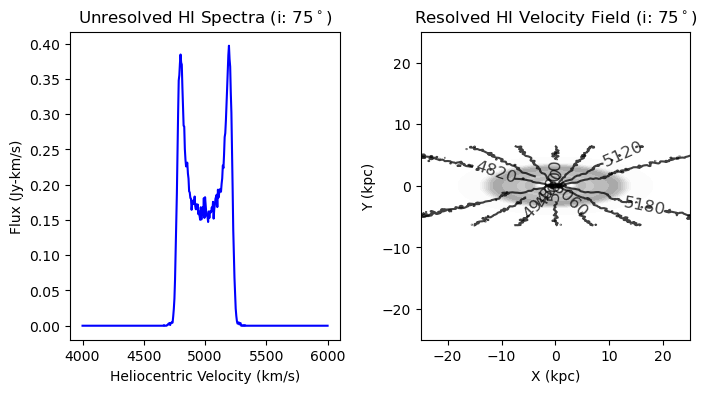

In [12]:
##########################################
#  GET INITIAL SPECTRA AND VELOCITY MAP  #
##########################################

# Generate a population of radial velocity and density maps
x, y, vrad_pop, dens_pop = build_galaxy_velcube(rotvel_spline, density_spline, HIradius, dx, dr_spline)

# Compute the unresolved 1-D spectra
vel, flux = unresolved_spectra(vrad_pop, dens_pop, cz)

# Compute 2-D velocity map
vrad_map, vel_levels, dens_map, dens_levels = resolved_spectra(cz, vrad_pop, dens_pop, velocity_step)

# Generate plots
# (1) Generate plot of plot of the rotation curve of the Galaxy
# (2) Draw the density profile of the Galaxy
# (3) Using matplotlib to generate the unresolved and resolved spectra plots
#
rot_curve = rotvel_plot(rad_spline, rotvel_spline)
density_profile = densprof_plot(rad_spline, density_spline)

In [13]:
#
# Create Control Sliders/Fields/Buttons
#
sigma_label = widgets.Label(value='$\sigma_V$ (km/s): ')
sigma_slider = widgets.IntSlider(min=0, max=50, step=1, value=vel_sigma,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='02d',
                                 layout=widgets.Layout(height='75px', min_height='50px', max_height='100px',
                                                       min_width='50px', width='200px', max_width='300px',
                                                       overflow='hidden'))
sigma_control = widgets.HBox([sigma_label, sigma_slider], 
                             layout=widgets.Layout(align_content='center', align_items='center'))

incl_label = widgets.Label(value='Inclination (deg): ')
incl_slider = widgets.IntSlider(min=0, max=80, step=1, value=incl,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='04d',
                                 layout=widgets.Layout(height='75px', min_height='50px', max_height='100px',
                                                       min_width='50px', width='200px', max_width='300px',
                                                       overflow='hidden'))
incl_control = widgets.HBox([incl_label, incl_slider], 
                             layout=widgets.Layout(align_content='center', align_items='center'))

cz_label = widgets.Label(value='$cz$ (km/s): ')
cz_slider = widgets.IntSlider(min=0, max=20000, step=10, value=cz,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='04d',
                                 layout=widgets.Layout(height='75px', min_height='50px', max_height='100px',
                                                       min_width='50px', width='200px', max_width='300px',
                                                       overflow='hidden'))
cz_control = widgets.HBox([cz_label, cz_slider], 
                             layout=widgets.Layout(align_content='center', align_items='center'))
cz_notice = widgets.HTML(value='', layout=widgets.Layout(height='75px', min_height='50px', max_height='100px',
                                                       min_width='50px', width='200px', max_width='300px'))

imgfile_label = widgets.HTML(value='Image Filename: ', 
                             layout=widgets.Layout(min_width='70px', width='100px', max_width='200px'))
imgfile_name = widgets.Text(value=image_filename, 
                             layout=widgets.Layout(min_width='100px', width='200px', max_width='300px'))
imgfile_control = widgets.HBox([imgfile_label, imgfile_name], 
                               layout=widgets.Layout(align_content='center', align_items='center'))

savefile_button = widgets.Button(description='Save Plots', disabled=False,
                                 tooltip='Click to save image file',
                                 layout=widgets.Layout(min_width='100px', width='150px', max_width='200px'))

savelink = widgets.HTML(value='')

#
# Spectra Widget
#
spectra2show = spectra_plots(x, y, vel, flux, vrad_map, vel_levels, dens_map, dens_levels)
spectra = widgets.Image(value=spectra2show, format='png', width=600, height=300)

#
# Display the plots
#

settings_top = widgets.HBox([sigma_control, imgfile_control, savefile_button, savelink], 
                               layout=widgets.Layout(align_content='center', align_items='center',
                                                     margin='0px', width='850px', 
                                                     overflow='hidden'))
settings_middle = widgets.HBox([cz_control, cz_notice, incl_control], 
                               layout=widgets.Layout(align_content='center', align_items='center',
                                                     margin='0px', width='850px', 
                                                     overflow='hidden'))

settings_bottom = widgets.HBox([rot_curve, density_profile], 
                            layout=widgets.Layout(margin='0px', width='850px', 
                                                  overflow='hidden'))
settings = widgets.VBox([settings_top, settings_middle, settings_bottom], 
                        layout=widgets.Layout(align_content='center', align_items='center',
                                              margin='0px', width='850px', 
                                              overflow='hidden'))
MainDisplay = widgets.VBox([settings, spectra], 
                           layout=widgets.Layout(align_content='center', align_items='center',
                                                 margin='0px', width='850px', 
                                                 overflow='hidden'))
display(MainDisplay)

#
# Direct functions to be called if various widgets change
#
sigma_slider.observe(sigma_changed, 'value')
cz_slider.observe(cz_changed, 'value')
incl_slider.observe(incl_changed, 'value')
rotcurve_spline.observe(update_rotcurve, names=['y'])
densprof_spline.observe(update_densprof, names=['y'])
savefile_button.on_click(make_printable_plot)

# Still need to add Warning about beam size